# Reading Data From MongoDB

In [3]:
import pymongo
import pandas as pd
from pymongo import MongoClient
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [4]:
client = MongoClient()
#point the client at mongo URI
client = MongoClient('mongodb://localhost:27017/')
#select database
db = client['Project']
#select the collection within the database
test = db.mldata
#convert entire collection to Pandas dataframe
test_ml = pd.DataFrame(list(test.find()))
print(test_ml)

                           _id  Age  DailyRate  DistanceFromHome  Education  \
0     624d0b9168ee6b66ba584f57   41       1102                 1          2   
1     624d0b9168ee6b66ba584f58   49        279                 8          1   
2     624d0b9168ee6b66ba584f59   37       1373                 2          2   
3     624d0b9168ee6b66ba584f5a   33       1392                 3          4   
4     624d0b9168ee6b66ba584f5b   27        591                 2          1   
...                        ...  ...        ...               ...        ...   
2935  624d0b9268ee6b66ba585ace   36        884                23          2   
2936  624d0b9268ee6b66ba585acf   39        613                 6          1   
2937  624d0b9268ee6b66ba585ad0   27        155                 4          3   
2938  624d0b9268ee6b66ba585ad1   49       1023                 2          3   
2939  624d0b9268ee6b66ba585ad2   34        628                 8          3   

      EnvironmentSatisfaction  HourlyRate  JobInvol

In [5]:
ml_df=test_ml.drop('_id', axis=1)

# Dependent and Independent Variables

In [6]:
y = ml_df["Attrition_Yes"]
X = ml_df.drop(["Attrition_Yes"],axis=1)

In [7]:
ml_df["Attrition_Yes"].value_counts()

0    2466
1     474
Name: Attrition_Yes, dtype: int64

In [8]:
print('No Attrition :', round(ml_df["Attrition_Yes"].value_counts()[0]/len(ml_df) * 100,2), '% of the dataset')
print('Attrition :', round(ml_df["Attrition_Yes"].value_counts()[1]/len(ml_df) * 100,2), '% of the dataset')

No Attrition : 83.88 % of the dataset
Attrition : 16.12 % of the dataset


# Smote for imbalanced dataset

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.15, 
                                                    random_state=2021,
                                                    stratify=y)
from imblearn.over_sampling import SMOTE
oversampled = SMOTE()
X_train_smote, y_train_smote = oversampled.fit_resample(X_train, y_train)

In [10]:
y_train_smote.value_counts()

0    2096
1    2096
Name: Attrition_Yes, dtype: int64

# 1. Naive Bayes
# i. MultinomialNB 

In [17]:
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


model =MultinomialNB()
params_NB = {'alpha': [0.00001,0.01, 0.1, 0.5, 1.0, 10.0 ]}
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2021)
mnbgrid = GridSearchCV(estimator=model,  
                 param_grid=params_NB,
                 cv=kfold,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy') 
mnbgrid.fit(X_train_smote, y_train_smote)

print(mnbgrid.best_params_)
print("Training score :",mnbgrid.best_score_)
y_pred = mnbgrid.predict(X_test)
print("Test score :",accuracy_score(y_test, y_pred))

y_pred_prob =  mnbgrid.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC_AUC_score :",roc_auc)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'alpha': 1e-05}
Training score : 0.5603576823187054
Test score : 0.5147392290249433
ROC_AUC_score : 0.5628473543966502


# ii. GaussianNB 

In [18]:
from sklearn.naive_bayes import GaussianNB
import numpy as np
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


model =GaussianNB()
params_NB = {'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]}
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2021)
nbgrid = GridSearchCV(estimator=model,  
                 param_grid=params_NB,
                 cv=kfold,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy') 
nbgrid.fit(X_train_smote, y_train_smote)

print(nbgrid.best_params_)
print("Training score :",nbgrid.best_score_)
y_pred = nbgrid.predict(X_test)
print("Test score :",accuracy_score(y_test, y_pred))

y_pred_prob =  nbgrid.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC_AUC_score :",roc_auc)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
{'var_smoothing': 1e-09}
Training score : 0.7564420650791799
Test score : 0.6462585034013606
ROC_AUC_score : 0.6867529501332318


# 2. DecisionTreeClassifier

In [19]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state=2021)

kfold = StratifiedKFold(n_splits=5,random_state=2021,shuffle=True)

parameters = {'max_depth':[x for x in range(10,20)],
              'min_samples_split':[x for x in range(10,16)],
              'min_samples_leaf':[x for x in range(8,16)]}

dtrcv = GridSearchCV(estimator=dtc, param_grid=parameters,
                  scoring='accuracy',cv=kfold,verbose=3)


dtrcv.fit(X_train_smote, y_train_smote)

print(dtrcv.best_params_)

print("Training score :",dtrcv.best_score_)
y_pred = dtrcv.predict(X_test)
print("Test score :",accuracy_score(y_test, y_pred))

y_pred_prob =  dtrcv.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC_AUC_score :",roc_auc)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
[CV 1/5] END max_depth=10, min_samples_leaf=8, min_samples_split=10;, score=0.863 total time=   0.0s
[CV 2/5] END max_depth=10, min_samples_leaf=8, min_samples_split=10;, score=0.862 total time=   0.0s
[CV 3/5] END max_depth=10, min_samples_leaf=8, min_samples_split=10;, score=0.885 total time=   0.0s
[CV 4/5] END max_depth=10, min_samples_leaf=8, min_samples_split=10;, score=0.866 total time=   0.0s
[CV 5/5] END max_depth=10, min_samples_leaf=8, min_samples_split=10;, score=0.885 total time=   0.0s
[CV 1/5] END max_depth=10, min_samples_leaf=8, min_samples_split=11;, score=0.863 total time=   0.0s
[CV 2/5] END max_depth=10, min_samples_leaf=8, min_samples_split=11;, score=0.862 total time=   0.0s
[CV 3/5] END max_depth=10, min_samples_leaf=8, min_samples_split=11;, score=0.885 total time=   0.0s
[CV 4/5] END max_depth=10, min_samples_leaf=8, min_samples_split=11;, score=0.866 total time=   0.0s
[CV 5/5] END max_depth=10, 

# 3. LogisticRegression

In [20]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2021)
parameters={'solver':['newton-cg','liblinear','lbfgs','sag','saga'],
            'penalty':['l1','l2','elasticnet','none'],
            'l1_ratio':[0.1,0.5,0.8]}

lrcv = GridSearchCV(estimator=model, param_grid=parameters,cv=kfold,scoring='accuracy')

lrcv.fit(X_train_smote, y_train_smote)

print(lrcv.best_params_)
print("Training score :",lrcv.best_score_)
y_pred = lrcv.predict(X_test)
print("Test score :",accuracy_score(y_test, y_pred))

y_pred_prob =  lrcv.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC_AUC_score :",roc_auc)

{'l1_ratio': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}
Training score : 0.8959922171240338
Test score : 0.8458049886621315
ROC_AUC_score : 0.6918538256566426


# 4 Discriminant Analysis

# i. Quadratic Discriminant Analysis

In [21]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2021)

qda = QuadraticDiscriminantAnalysis()

qdaRes= cross_val_score(estimator=qda,X=X_train_smote,y=y_train_smote ,scoring='accuracy',cv=kfold)
qdaRoc= cross_val_score(estimator=qda,X=X_train_smote,y=y_train_smote ,scoring='roc_auc',cv=kfold)

print(qdaRes)
print("Accuracy_Score :",qdaRes.mean())

print(qdaRoc)
print("Roc_Auc_Score :",qdaRoc.mean())

[0.82121573 0.81168057 0.83174224 0.82100239 0.83890215]
Accuracy_Score : 0.8249086166336218
[0.92850892 0.93650415 0.94169548 0.9085617  0.94102904]
Roc_Auc_Score : 0.9312598578543179


# ii. Linear Discriminant Analysis 

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2021)

lda = LinearDiscriminantAnalysis()

ldaRes = cross_val_score(estimator=lda,X=X_train_smote,y=y_train_smote ,scoring='accuracy',cv=kfold)
ldaRoc = cross_val_score(estimator=lda,X=X_train_smote,y=y_train_smote ,scoring='roc_auc',cv=kfold)

print(ldaRes)
print("Accuracy_Score :",ldaRes.mean())

print(ldaRoc)
print("Roc_Auc_Score :",ldaRoc.mean())

[0.87485101 0.89511323 0.8902148  0.87350835 0.89618138]
Accuracy_Score : 0.8859737555505618
[0.94739743 0.9546994  0.96041832 0.94065311 0.95758739]
Roc_Auc_Score : 0.9521511285861568


# 5. BaggingClassifier 

In [24]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
parameters = {'base_estimator':[DecisionTreeClassifier(random_state=2021),
                                KNeighborsClassifier(),
                                RandomForestClassifier(random_state=2021)],
              'n_estimators': [10,20,30]}

model_bg = BaggingClassifier(random_state=2021,oob_score=True,
                             max_features=X.shape[1],
                             max_samples=int(np.floor(X.shape[0]*0.8)))
bg_cv = GridSearchCV(model_bg, param_grid=parameters,
                  cv=kfold,scoring='accuracy')

bg_cv.fit( X_train_smote , y_train_smote )

print(bg_cv.best_params_)

print("Training score :",bg_cv.best_score_)
y_pred = bg_cv.predict(X_test)
print("Test score :",accuracy_score(y_test, y_pred))

y_pred_prob = bg_cv.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC_AUC_score :",roc_auc)

{'base_estimator': RandomForestClassifier(random_state=2021), 'n_estimators': 30}
Training score : 0.9766232103794437
Test score : 0.9342403628117913
ROC_AUC_score : 0.8469927674153027


# 6. KNN Classification

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.metrics import accuracy_score

knn=KNeighborsClassifier()
kfold=StratifiedKFold(n_splits=5,random_state=2021,shuffle=True)

parameters={'n_neighbors':[1,3,5,7,9,11,13,15]}

knncv=GridSearchCV(estimator=knn, param_grid=parameters,scoring='accuracy',cv=kfold)

knncv.fit(X_train_smote, y_train_smote)

print(knncv.best_params_)
print("Training score :",knncv.best_score_)
y_pred = knncv.predict(X_test)
print("Test score :",accuracy_score(y_test, y_pred))

y_pred_prob = knncv.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC_AUC_score :",roc_auc)

{'n_neighbors': 1}
Training score : 0.950386441410817
Test score : 0.9410430839002267
ROC_AUC_score : 0.9079558431671108


# 7. XGBoost

In [27]:
from xgboost import XGBClassifier

parameters={'max_depth':[3,5,7],
            'learning_rate':[0.1,0.5]}

clf=XGBClassifier(random_state=2021,eval_metric='mlogloss')
kfold=StratifiedKFold(n_splits=5,random_state=2021,shuffle=True)
xgbcv=GridSearchCV(estimator=clf, param_grid=parameters,
                scoring='accuracy',cv=kfold,verbose=2)

xgbcv.fit(X_train_smote, y_train_smote)

print(xgbcv.best_params_)

print("Training score :",xgbcv.best_score_)
y_pred = xgbcv.predict(X_test)
print("Test score :",accuracy_score(y_test, y_pred))

y_pred_prob =  xgbcv.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC_AUC_score :",roc_auc)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................learning_rate=0.1, max_depth=3; total time=   0.4s
[CV] END .....................learning_rate=0.1, max_depth=3; total time=   0.3s
[CV] END .....................learning_rate=0.1, max_depth=3; total time=   0.3s
[CV] END .....................learning_rate=0.1, max_depth=3; total time=   0.3s
[CV] END .....................learning_rate=0.1, max_depth=3; total time=   0.3s
[CV] END .....................learning_rate=0.1, max_depth=5; total time=   0.5s
[CV] END .....................learning_rate=0.1, max_depth=5; total time=   0.5s
[CV] END .....................learning_rate=0.1, max_depth=5; total time=   0.5s
[CV] END .....................learning_rate=0.1, max_depth=5; total time=   0.5s
[CV] END .....................learning_rate=0.1, max_depth=5; total time=   0.5s
[CV] END .....................learning_rate=0.1, max_depth=7; total time=   0.7s
[CV] END .....................learning_rate=0.1, 

# 8. RandomForestClassifier

In [28]:
from sklearn.ensemble import RandomForestClassifier

parameters={'max_features': [2,3,4,5]}
clf=RandomForestClassifier(random_state=2021)
kfold=StratifiedKFold(n_splits=5,random_state=2021,shuffle=True)
rf_cv=GridSearchCV(estimator=clf, param_grid=parameters,
                scoring='accuracy',cv=kfold,verbose=2)

rf_cv.fit(X_train_smote, y_train_smote)

print(rf_cv.best_params_)

print("Training score :",rf_cv.best_score_)
y_pred = rf_cv.predict(X_test)
print("Test score :",accuracy_score(y_test, y_pred))

y_pred_prob = rf_cv.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC_AUC_score :",roc_auc)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .....................................max_features=2; total time=   0.3s
[CV] END .....................................max_features=2; total time=   0.3s
[CV] END .....................................max_features=2; total time=   0.3s
[CV] END .....................................max_features=2; total time=   0.3s
[CV] END .....................................max_features=2; total time=   0.3s
[CV] END .....................................max_features=3; total time=   0.3s
[CV] END .....................................max_features=3; total time=   0.4s
[CV] END .....................................max_features=3; total time=   0.4s
[CV] END .....................................max_features=3; total time=   0.3s
[CV] END .....................................max_features=3; total time=   0.3s
[CV] END .....................................max_features=4; total time=   0.4s
[CV] END .....................................max

# 9. VotingClassifier

In [29]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [30]:
dtc = DecisionTreeClassifier(random_state=2021)
knn = KNeighborsClassifier()
rfc=RandomForestClassifier(random_state=2021)

votingclf = VotingClassifier(estimators=[('DT',dtc),
                                      ('KNN',knn),
                                      ('RF',rfc)],
                          voting='soft')
params = {'KNN__n_neighbors':[1,3,5,7,9,11],
          'DT__max_depth':[x for x in range(10,20)],
          'RF__max_features': [2,3,4,5]
         }
vgrid = GridSearchCV(estimator=votingclf,param_grid=params ,cv=2)
vgrid.fit(X_train_smote,y_train_smote)
print(vgrid.best_params_)

print("Training score :",vgrid.best_score_)
y_pred = vgrid.predict(X_test)
print("Test score :",accuracy_score(y_test, y_pred))

y_pred_prob = vgrid.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC_AUC_score :",roc_auc)

{'DT__max_depth': 10, 'KNN__n_neighbors': 1, 'RF__max_features': 5}
Training score : 0.9522900763358779
Test score : 0.963718820861678
ROC_AUC_score : 0.9214693566806242


## Feature Importance

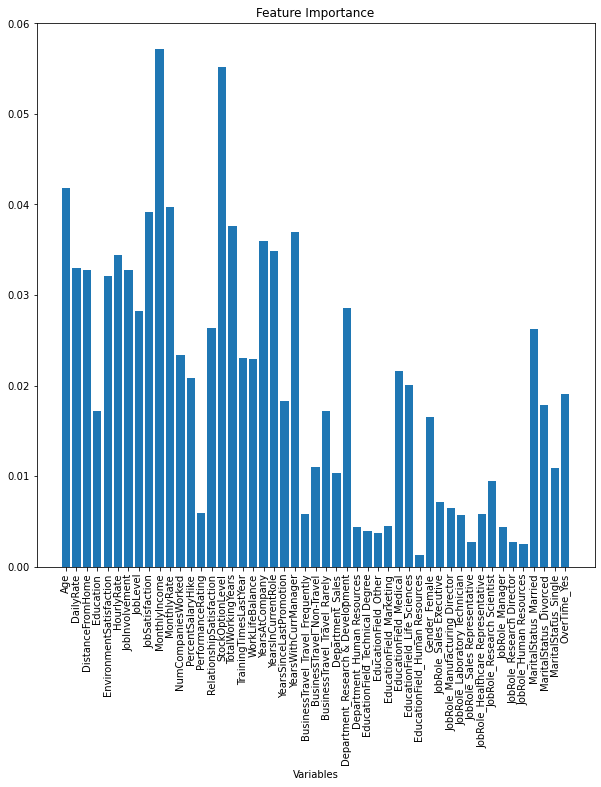

In [39]:
import matplotlib.pyplot as plt
best_model = rf_cv.best_estimator_
best_model.feature_importances_

ind = np.arange(X.shape[1])
plt.bar(ind,best_model.feature_importances_)
plt.xticks(ind,(X.columns),rotation=90)
plt.title('Feature Importance')
plt.xlabel("Variables")
plt.rcParams['figure.figsize'] = [10,10]
plt.show()